# C/GMRES (single-shooting) example

In [25]:
import numpy as np
import scipy as sci
import time
import matplotlib.pyplot as plt


class CGMRES:
    def __init__(self):
        self.t0 = 0.0
        self.T_mpc = 20
        # self.T_mpc = 0.004
        # self.T_mpc = 0.0
        self.dt_mpc = 4e-3
        # self.dt_mpc = 1e-3

        ### horizon
        self.Tf = 1.0
        self.N = 5
        self.alpha = 0.5

        ### current horizon length
        self.Tcur = 0.0
        self.dtau = self.Tcur / self.N

        ### C/GMRES parameters
        self.zeta = 1.0/self.dt_mpc
        self.h_fd = 1e-6
        self.m_gmres = 5
        self.initial_error_tol = 1e-6

        ### cost weight
        self.q = np.array([1.0, 10.0])
        self.r = np.array([1.0, 0.01])
        self.qf = np.array([1.0, 10.0])
        
        ### bound of input
        self.umin = 0.0
        self.umax = 1.0

        ### initial condition
        self.x0 = np.array([2.0, 0.0])
        self.u0 = np.array([0.01, 0.9])
        self.lam0 = np.array([0.0, 0.0])
        self.mu0 = np.array([0.03])
        self.v0 = np.concatenate([self.u0, self.mu0])
        self.y0 = np.concatenate([self.x0, self.lam0])

        ### reference
        self.xref = np.array([0.0, 0.0])
        self.uref = np.array([0.0, 0.0])

        ### dimension
        self.nx = len(self.x0)
        self.nu = len(self.u0)
        self.nc = len(self.mu0)
        self.nv = self.nu + self.nc
        self.ny = 2*self.nx

        ### variable
        # self.X = np.zeros((self.N + 1, self.nx))
        self.X = np.tile(self.y0, self.N + 1)
        self.Xdot = np.zeros(self.X.shape)
        # self.U = np.zeros(self.N * self.nv)
        self.U = np.tile(self.v0, self.N)
        # self.Lam = np.zeros((self.N + 1, self.nx))
        self.Udot = np.zeros(self.U.shape)

        self.u = np.zeros(self.nu)
        self.xt = np.zeros(self.nx)

        self.opt_error = None

        ### local constants
        self.a = -1
        self.b = -1

    def calc_f(self, x: np.ndarray, u: np.ndarray, t: float):
        f = np.array([
            x[1],
            self.a * x[0] + self.b * x[1] * u[0]
        ])
        return f
    
    def calc_fx(self, x: np.ndarray, u: np.ndarray, t: float):
        fx = np.array([
            [0, 0],
            [self.a, self.b * u[0]]
        ])
        return fx
        
    def calc_fu(self, x: np.ndarray, u: np.ndarray, t: float):
        fu = np.array([
            [0, 0],
            [self.b * x[1], 0]
        ])
        return fu
    

    def calc_l(self, x: np.ndarray, u: np.ndarray, t: float):
        xres = x - self.xref
        ures = u - self.uref
        l = 0.5*self.q[0]*xres[0]**2 + 0.5*self.q[1]*xres[1]**2 \
            + 0.5*self.r[0]*ures[0]**2 - self.r[1]*ures[1]
        return l

    def calc_lx(self, x: np.ndarray, u: np.ndarray, t: float):
        xres = x - self.xref
        ures = u - self.uref
        lx = np.array([
            self.q[0] * xres[0],
            self.q[1] * xres[1]
        ])
        return lx

    def calc_lu(self, x: np.ndarray, u: np.ndarray, t: float):
        xres = x - self.xref
        ures = u - self.uref
        lu = np.array([
            self.r[0] * ures[0],
            -self.r[1]
        ])
        return lu
        
    def calc_lf(self, x: np.ndarray, t: float):
        xres = x - self.xref
        lf = 0.5*self.qf[0]*xres[0]**2 + 0.5*self.qf[1]*xres[1]**2
        return lf

    def calc_lfx(self, x: np.ndarray, t:float):
        lfx = np.array([
            self.qf[0]*x[0],
            self.qf[1]*x[1]
        ])
        return lfx

    def calc_C(self, x: np.ndarray, u: np.ndarray, t: float):
        C = np.array([
            (u[0] - 0.5*(self.umax + self.umin))**2 + u[1]**2 \
                - (0.5*(self.umax - self.umin))**2
        ])
        return C
    
    def calc_Cx(self, x: np.ndarray, u: np.ndarray, t: float):
        Cx = np.array([
            [0, 0]
        ])
        return Cx

    def calc_Cu(self, x: np.ndarray, u: np.ndarray, t: float):
        Cu = np.array([
            [2*(u[0] - 0.5*(self.umin + self.umax)), 2*u[1]]
        ])
        return Cu
    

    def calc_H(self, x: np.ndarray, u: np.ndarray, lam: np.ndarray, mu: np.ndarray, t: float):
        H = self.calc_l(x, u, t) + self.calc_f(x, u, t).T @ lam + self.calc_C(x, u, t).T @ mu
        return H
    
    def calc_Hx(self, x: np.ndarray, u: np.ndarray, lam: np.ndarray, mu: np.ndarray, t: float):
        Hx = self.calc_lx(x, u, t) + self.calc_fx(x, u, t).T @ lam \
            + self.calc_Cx(x, u, t).T @ mu
        return Hx
    
    def calc_Hu(self, x: np.ndarray, u: np.ndarray, lam: np.ndarray, mu: np.ndarray, t: float):
        Hu = self.calc_lu(x, u, t) + self.calc_fu(x, u, t).T @ lam \
            + self.calc_Cu(x, u, t).T @ mu
        return Hu
    
    def calc_Hv(self, x: np.ndarray, v: np.ndarray, lam: np.ndarray, t: float):
        u = v[0:self.nu]
        mu = v[self.nu:]
        Hu = self.calc_Hu(x, u, lam, mu, t)
        C = self.calc_C(x, u, t)
        return np.concatenate([Hu, C])
    
    def calc_Hvv(self, x: np.ndarray, v: np.ndarray, lam: np.ndarray, t: float):
        Hvv = np.zeros((self.nv, self.nv))
        Hv = self.calc_Hv(x, v, lam, t)
        for i in range(self.nv):
            e = np.eye(self.nv)[i]
            Hvv[:, i] = (self.calc_Hv(x, v + self.h_fd*e, lam, t) - Hv) / self.h_fd
        return Hvv

    def rollout_x(self, xt: np.ndarray, U: np.ndarray, t:float):
        U = U.reshape((self.N, self.nv))
        X = np.empty((self.N + 1, self.nx))
        X[0] = xt

        for i in range(self.N):
            u = U[i][:self.nu]
            X[i + 1] = X[i] + self.calc_f(X[i], u, t + i*self.dtau) * self.dtau

        return X

    def rollout_lam(self, X: np.ndarray, U:np.ndarray, t:float):
        X = X.reshape((self.N + 1, self.nx))
        U = U.reshape((self.N, self.nv))
        Lam = np.empty((self.N + 1, self.nx))
        Lam[self.N] = self.calc_lfx(X[self.N], t)
        
        for i in range(self.N - 1, -1, -1):
            u  = U[i][:self.nu]
            mu  = U[i][self.nu:]
            Lam[i] = Lam[i + 1] + self.calc_Hx(X[i], u, Lam[i + 1], mu, t + i*self.dtau) * self.dtau
        
        return Lam


    def calc_F(self, U: np.ndarray, X: np.ndarray, xt: np.ndarray, t: float):
        U = U.reshape((self.N, self.nv))
        X = X.reshape((self.N + 1, self.ny))
        F = np.empty((self.N, self.nv))

        xs = X[:, :self.nx]
        lams = X[:, self.nx:]
        # print('xs from calc_F:\n', xs)
        # print('rank of xs:', np.linalg.matrix_rank(xs))
        # print('lams from calc_F:\n', lams)
        # print('rank of lams:', np.linalg.matrix_rank(lams))

        for i in range(self.N):
            x = X[i][:self.nx]
            lam = X[i + 1][self.nx:]
            Hv = self.calc_Hv(x, U[i], lam, t + i*self.dtau)
            F[i] = Hv
        
        return F.reshape(-1)

    def calc_G(self, U: np.ndarray, X: np.ndarray, xt: np.ndarray, t: float):
        U = U.reshape((self.N, self.nv))
        X = X.reshape((self.N + 1, self.ny))
        us = U[:, :self.nu]
        mus = U[:, self.nu:]
        xs = X[:, :self.nx]
        lams = X[:, self.nx:]
        G = np.empty((self.N + 1, self.ny))

        st = xs[0] - xt
        hx = lams[0] - lams[1] - self.calc_Hx(xs[0], us[0], lams[1], mus[0], t) * self.dtau
        G[0][:self.nx] = st
        G[0][self.nx:] = hx
        
        for i in range(0, self.N - 1):
            st = xs[i + 1] - xs[i] - self.calc_f(xs[i], us[i], t + i*self.dtau) * self.dtau
            hx = lams[i + 1] - lams[i + 2] \
                - self.calc_Hx(xs[i + 1], us[i + 1], lams[i + 2], mus[i + 1], t + i*self.dtau)\
                * self.dtau
            G[i + 1][:self.nx] = st
            G[i + 1][self.nx:] = hx

        st = xs[self.N] - xs[self.N - 1] \
            - self.calc_f(xs[self.N - 1], us[self.N - 1], t + self.T_mpc) * self.dtau
        hx = lams[self.N] - self.calc_lfx(xs[self.N], t + self.T_mpc)
        G[self.N][:self.nx] = st
        G[self.N][self.nx:] = hx

        return G.reshape(-1)

    def calc_K(self, U: np.ndarray, Z: np.ndarray, xt: np.ndarray, t: float):
        U = U.reshape((self.N, self.nv))
        us = U[:, :self.nu]
        mus = U[:, self.nu:]
        Z = Z.reshape((2*(self.N + 1), self.nx))
        Zx = Z[::2]
        Zlam = Z[1::2]

        X = np.empty(Z.shape)
        xs = X[::2]
        lams = X[1::2]

        xs[0] = xt + Zx[0]
        for i in range(self.N):
            xs[i + 1] = xs[i] + self.calc_f(xs[i], us[i], t + i*self.dtau) * self.dtau \
                + Zx[i + 1]
        
        lams[self.N] = self.calc_lfx(xs[self.N], t + self.T_mpc) + Zlam[self.N]
        for i in range(self.N - 1, -1, -1):
            lams[i] = lams[i + 1] \
                + self.calc_Hx(xs[i], us[i], lams[i + 1], mus[i], t + i*self.dtau) * self.dtau\
                + Zlam[i]

        return X.reshape(-1)

    def update_solution(self, xt: np.ndarray, t: float):
        U = self.U
        Udot0 = self.Udot
        X = self.X
        Xdot0 = self.Xdot

        xdot = self.calc_f(xt, U[0:self.nu], t)
        G = self.calc_G(U, X, xt, t)

        ### Arnoldi iteration: get Hessenberg matrix and ONB
        Hm_, Vm1, r0_norm = self.arnoldi_fdgmres(U, Udot0, X, Xdot0, xt, t)

        # print('norm of G:', np.linalg.norm(G))
        # print('G:\n', G.reshape((self.N + 1, -1)))
        # print('Hm_:\n',Hm_)
        # print('Vm1:\n',Vm1)
        # print('Vm1.T @ Vm:\n',Vm1.T @ Vm1)
        # print('rank of Vm1.T @ Vm1:\n',np.linalg.matrix_rank(Vm1.T @ Vm1))
        # print('rank of Vm1:\n', np.linalg.matrix_rank(Vm1.T))
        # print('r0_norm:\n', r0_norm)

        ### You can solve directory: Hm_ * y = ||r0|| e1
        if False:
            e1 = np.eye(self.m_gmres + 1)[0]
            y, residual, rank, svals = sci.linalg.lstsq(Hm_, r0_norm * e1)
            self.Udot = Udot0 + Vm1[:, :self.m_gmres] @ y
            self.U = U + self.Udot * self.dt_mpc

            xdot = self.calc_f(xt, U[0:self.nu], t)
            G = self.calc_G(U, X, xt, t)
            K = self.calc_K(U + self.Udot*self.h_fd, (1 - self.zeta*self.h_fd)*G, xt + self.h_fd*xdot, t + self.h_fd)
            self.Xdot = (K - X) / self.h_fd
            self.X = X + self.Xdot * self.dt_mpc
            # print('X:\n', self.X)

            F_new = self.calc_F(self.U, self.X, xt, t)
            self.opt_error = np.linalg.norm(F_new)
            return

        ### Givens rotation: Triangulate Hm_
        e1 = np.zeros(self.m_gmres + 1)
        e1[0] = 1
        Rm_, gm_ = self.givens_rotation(Hm_, r0_norm*e1)
        
        ### Backward substitution: solve Rm * y = gm
        y = self.backward_substitution(Rm_[0:self.m_gmres, :], gm_[0:self.m_gmres])

        self.Udot = Udot0 + Vm1[:, 0:self.m_gmres] @ y
        self.U = U + self.Udot * self.dt_mpc
        
        ### Expanding Xdot
        xdot = self.calc_f(xt, U[0:self.nu], t)
        G = self.calc_G(U, X, xt, t)
        K = self.calc_K(U + self.Udot*self.h_fd, (1 - self.zeta*self.h_fd)*G, xt + self.h_fd*xdot, t + self.h_fd)
        self.Xdot = (K - X) / self.h_fd
        # print('G:\n', G.reshape((self.N + 1, -1)))
        # print('K:\n', K.reshape(-1, self.ny))
        # print('X:\n', X)
        #
        # self.Xdot = (self.calc_K(U + self.Udot * self.h_fd, (1 - self.zeta * self.h_fd) * G,
        # xt + self.h_fd * xdot, t + self.h_fd) - X) / self.h_fd
        # print('norm of G:', np.linalg.norm(G))
        # print('G:\n', G.reshape((self.N + 1, -1)))
        # print('Udot:\n', self.Udot)
        # print('U:\n', self.U)
        # X_ro = self.rollout_x(xt, U, t)
        # Xh_ro = self.rollout_x(xt + xdot*self.h_fd, U, t + self.h_fd)
        # print('X_ro:\n', X_ro)
        # print('Xh_ro:\n', Xh_ro)
        # print('Lam_ro:\n', self.rollout_lam(X_ro, U, t))
        # print('Lamh_ro:\n', self.rollout_lam(Xh_ro, U, t))
        # print('norm of Xdot:\n', np.linalg.norm(self.Xdot))
        # print('xdot:\n', xdot)
        # print()
        self.X = X + self.Xdot * self.dt_mpc
        # print('X:\n', self.X)

        F_new = self.calc_F(self.U, self.X, xt, t)
        self.opt_error = np.linalg.norm(F_new)
        # print('norm of F:', self.opt_error)
        n1 = np.linalg.norm(self.Xdot)
        n2 = np.linalg.norm(self.Udot)
        # print('Xdot, Udot:')
        # print(n1, n2)
        # print('Xdot:\n', self.Xdot.reshape(self.N + 1, -1))
        # print('Udot:\n', self.Udot.reshape(self.N, -1))
        return

    def arnoldi_fdgmres(
            self, U: np.ndarray, Udot0: np.ndarray, X: np.ndarray, Xdot: np.ndarray,
            xt: np.ndarray, t: float
            ):
        xdot = self.calc_f(xt, U[0:self.nu], t)
        xt_h = xt + xdot * self.h_fd
        t_h = t + self.h_fd
        # print('xdot:\n', xdot)
        # print('U:\n', U)
        # print('Udot0:\n', Udot0.reshape(self.N, -1))
        # print('rank of Udot0:\n', np.linalg.matrix_rank(Udot0.reshape(self.N, -1)))

        Gxt = self.calc_G(U, X, xt_h, t_h)
        Fxt = self.calc_F(U, X, xt_h, t_h)
        U_h = U + Udot0 * self.h_fd
        K_lhs = self.calc_K(U_h, Gxt, xt_h, t_h)
        FUXxt = self.calc_F(U_h, K_lhs, xt_h, t_h)
        # print('xt_h', xt_h)
        # print('Gxt:\n', Gxt.reshape((self.N + 1, self.ny)))
        # print('Fxt:\n', Fxt.reshape((self.N, self.nv)))
        # print('K_lhs:\n', K_lhs.reshape((self.N + 1, self.ny)))
        # print('FUXxt:\n', FUXxt.reshape((self.N, self.nv)))

        G = self.calc_G(U, X, xt, t)
        F = self.calc_F(U, X, xt, t)
        K_rhs = self.calc_K(U, (1 - self.zeta*self.h_fd)*G, xt_h, t_h)
        FXxt = self.calc_F(U, K_rhs, xt_h, t_h)
        # print('G:\n', G.reshape((self.N + 1, self.ny)))
        # print('F:\n', F.reshape((self.N, self.nv)))
        # print('K_rhs:\n', K_rhs.reshape((self.N + 1, self.ny)))
        # print('FXxt:\n', FXxt.reshape((self.N, self.nv)))

        ### initial residual: r0 = b - A*Udot0
        b = ((1 - self.zeta*self.h_fd)*F - FXxt) / self.h_fd
        A_Udot0 = (FUXxt - Fxt) / self.h_fd
        r0 = b - A_Udot0
        r0_norm = np.linalg.norm(r0)

        # print('r0:\n', r0.reshape((self.N, -1)))
        # print('rank of r0:\n', np.linalg.matrix_rank(r0.reshape((self.N, -1))))

        ### Arnoldi iteration
        Hm_ = np.zeros((self.m_gmres + 1, self.m_gmres))
        Vm1 = np.zeros((self.N*self.nv, self.m_gmres + 1))
        Vm1[:, 0] = r0 / r0_norm

        Av = np.zeros(Vm1.shape)
        Av[:, 0] = Vm1[:, 0].copy()

        for j in range(self.m_gmres):
            U_h = U + Vm1[:, j] * self.h_fd
            K_lhs = self.calc_K(U_h, Gxt, xt_h, t_h)
            FUXxt = self.calc_F(U_h, K_lhs, xt_h, t_h)
            Avj = (FUXxt - Fxt) / self.h_fd
            Av[:, j + 1] = Avj.copy()

            for i in range(j+1):
                Hm_[i, j] = Avj.T @ Vm1[:, i]
            
            vj1_hat = Avj
            for i in range(j+1):
                vj1_hat = vj1_hat - Hm_[i, j]*Vm1[:, i]
            
            Hm_[j+1, j] = np.linalg.norm(vj1_hat)
            Vm1[:, j+1] = vj1_hat / Hm_[j+1, j]

        # print('Av:\n', Av)
        # print('rank of Av:\n', np.linalg.matrix_rank(Av))

        return Hm_, Vm1, r0_norm

    def givens_rotation(self, Hm_: np.ndarray, gm_: np.ndarray):
        Rm_ = Hm_

        for i in range(self.m_gmres):
            den = np.sqrt(Rm_[i][i]**2 + Rm_[i+1][i]**2)
            ci = Rm_[i][i] / den
            si = Rm_[i+1][i] / den

            rot = np.array([[
                [ci, si],
                [-si, ci]
            ]])

            Rm_[i:i+2, :] = rot @ Rm_[i:i+2, :]
            gm_[i:i+2] = rot @ gm_[i:i+2]
        
        return Rm_, gm_

    def backward_substitution(self, Rm: np.ndarray, gm: np.ndarray):
        y = np.zeros(self.m_gmres)

        y = np.zeros(self.m_gmres)
        for i in range(self.m_gmres - 1, -1, -1):
            y[i] = (gm[i] - (Rm[i, i+1:].T @ y[i+1:])) / Rm[i, i]
        
        return y

    def update_horizon(self, t: float):
        self.Tcur = self.Tf * (1 - np.exp(-self.alpha * (t - self.t0)))
        self.dtau = self.Tcur / self.N

    def get_control_input(self):
        return self.U[0:self.nu]

    def RK4(self, x, u, t, dt):
        k1 = self.calc_f(x, u, t)
        k2 = self.calc_f(x + 0.5*dt*k1, u, t)
        k3 = self.calc_f(x + 0.5*dt*k2, u, t)
        k4 = self.calc_f(x + dt*k3, u, t)
        x_next = x + (k1 + 2*k2 + 2*k3 + k4)*dt/6
        return x_next

    def initial_newton(self):
        self.lam0 = self.calc_lfx(self.x0, self.t0)
        # print('lam0:\n', self.lam0)
        self.y0 = np.concatenate([self.x0, self.lam0])
        opt_error = np.inf

        while opt_error >= self.initial_error_tol / np.sqrt(self.N):
            Hvv = self.calc_Hvv(self.x0, self.v0, self.lam0, self.t0)
            Hv = self.calc_Hv(self.x0, self.v0, self.lam0, self.t0)
            dv = -np.linalg.solve(Hvv, Hv)
            self.v0 = self.v0 + dv
            opt_error = np.linalg.norm(Hv)
            # print('Hv')
            # print(Hv)

        self.opt_error = opt_error / np.sqrt(self.N)
        self.u0 = self.v0[0:self.nu]
        self.mu0 = self.v0[self.nu:]
        
        self.U = np.tile(self.v0, self.N)
        self.y0 = np.concatenate([self.x0, self.lam0])
        self.X = np.tile(self.y0, self.N + 1)

    def run(self):
        N_mpc = int(self.T_mpc / self.dt_mpc)
        t_hist = np.linspace(0, self.T_mpc, N_mpc+1)
        x_hist = []
        v_hist = []
        opt_error_hist = []

        ### initialize MPC
        self.initial_newton()

        print('initial input (u, udummy, mu):\n', self.v0)
        print('initial optError:\n', self.opt_error)

        self.U = np.tile(self.v0, self.N)
        self.Udot = self.U.copy()
        self.Udot = np.zeros(self.U.shape)
        
        self.X = np.tile(self.y0, self.N + 1)

        t = 0.0
        xt = self.x0
        u = self.U[0:self.nv]

        ### MPC simulation
        timer = time.perf_counter()
        for i, t in enumerate(t_hist):
            print('t, x(t):\n', t, ',\n', xt)

            ### C/GMRES
            self.update_horizon(t)
            self.update_solution(xt, t)
            u = self.get_control_input()
            # print('Udot:\n', self.Udot)
            # print('Xdot:\n', self.Xdot)
            # print('norm of Xdot:\n', np.linalg.norm(self.Xdot))
            # print('u:\n', u)

            ### history
            x_hist.append(xt)
            v_hist.append(self.U[0:self.nv])
            opt_error_hist.append(self.opt_error)

            ### next state
            xt = self.RK4(xt, u, t, self.dt_mpc)
            t = t + self.dt_mpc

        elapsed = time.perf_counter() - timer

        print()
        print('final state:\n', xt)
        print('computation time[s]:\n', elapsed)
        # print('final norm of Udot:\n', self.Udot)

        self.t_hist = t_hist
        self.x_hist = np.array(x_hist)
        self.v_hist = np.array(v_hist)
        self.opt_error_hist = np.array(opt_error_hist)
        return

np.set_printoptions(precision=6, linewidth=150)

cgmres = CGMRES()
cgmres.initial_newton()
cgmres.run()


initial input (u, udummy, mu):
 [0.028394 0.166095 0.030103]
initial optError:
 2.2994322931035757e-13

final state:
 [0.078675 0.013647]
computation time[s]:
 12.542526132019702


In [26]:
nx = cgmres.nx
nu = cgmres.nu
# y0 = cgmres.y0
# v0 = cgmres.v0
U = cgmres.U
X = cgmres.X
Xdot = cgmres.Xdot
Z = np.zeros(X.shape)
# print(X.reshape(cgmres.N + 1, -1))

x = cgmres.x0
lam = cgmres.lam0
u = cgmres.u0
mu = cgmres.mu0
t = 0.0

print('x:', x)
print('lam:', lam)
print('u:', u)
print('mu:', mu)
print()

f = cgmres.calc_f(x, u, t)
fx = cgmres.calc_fx(x, u, t)
lx =  cgmres.calc_lx(x, u, t)
lfx = cgmres.calc_lfx(x, t)
Cx = cgmres.calc_Cx(x, u, t).T @ mu
Hx = cgmres.calc_Hx(x, u, lam, mu, t)

print('f:\n', f)
print('fx:\n', fx)
print('lx:\n', lx)
print('lfx:\n', lfx)
print('Cx:\n', Cx)
print('Hx:\n', Hx)

x = X[:nx]
print(x)
print('Xdot:\n', Xdot)

G = cgmres.calc_G(U, X, x, t)
K = cgmres.calc_K(U, G, x, t)
print('X:\n', X)
print('G:\n', G)
print('K:\n', K)

G2 = cgmres.calc_G(U, K, x, t)
K2 = cgmres.calc_K(U, G, x, t)
print('G2:\n', G2)
print('K2:\n', K2)


x: [2. 0.]
lam: [2. 0.]
u: [0.028394 0.166095]
mu: [0.030103]

f:
 [ 0. -2.]
fx:
 [[ 0.        0.      ]
 [-1.       -0.028394]]
lx:
 [2. 0.]
lfx:
 [2. 0.]
Cx:
 [0. 0.]
Hx:
 [2. 0.]
[0.078675 0.013647]
Xdot:
 [ 0.013805 -0.078947  0.756017 -1.27247  -0.001984 -0.081441  0.528495 -1.123833 -0.018271 -0.080547  0.334089 -0.974039 -0.03438  -0.076064
  0.172067 -0.828398 -0.049592 -0.068057  0.040613 -0.691663 -0.063204 -0.056868 -0.063204 -0.568683]
X:
 [ 0.078675  0.013647  0.893571 -0.785995  0.081405 -0.002147  0.714478 -0.81683   0.080975 -0.018414  0.534732 -0.817365  0.077293 -0.034467
  0.361226 -0.786592  0.0704   -0.049604  0.200895 -0.724398  0.060479 -0.063171  0.060479 -0.631714]
G:
 [ 0.000000e+00  0.000000e+00  1.075806e-13 -9.682010e-08  1.269384e-15 -6.801440e-09 -1.327272e-13 -1.403446e-07 -8.817708e-15 -1.173445e-08
  9.048318e-14 -1.534737e-07 -4.215378e-15 -1.492266e-08  4.674039e-14 -1.373005e-07 -2.595146e-15 -1.509933e-08  1.192657e-13 -1.049430e-07
  1.114733e-14 

### Plot result

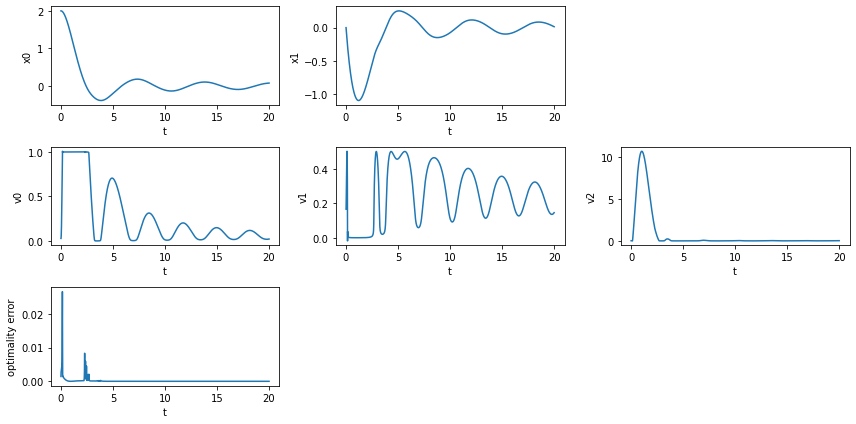

In [27]:
col = max(cgmres.nx, cgmres.nv)

fig, axes = plt.subplots(3, col, figsize=(12, 6), tight_layout=True)

for j in range(col):
    if j >= cgmres.nx:
        fig.delaxes(axes[0, j])
        break
    axes[0, j].set_xlabel('t')
    axes[0, j].set_ylabel(f'x{j}')
    axes[0, j].plot(cgmres.t_hist, cgmres.x_hist[:, j])

for j in range(col):
    if j >= cgmres.nv:
        fig.delaxes(axes[1, j])
        break
    axes[1, j].set_xlabel('t')
    axes[1, j].set_ylabel(f'v{j}')
    axes[1, j].plot(cgmres.t_hist, cgmres.v_hist[:, j])


axes[2, 0].set_xlabel('t')
axes[2, 0].set_ylabel(f'optimality error')
axes[2, 0].plot(cgmres.t_hist, cgmres.opt_error_hist)
for j in range(1, col):
    fig.delaxes(axes[2, j])
    


In [28]:
# cgmres.v_hist[1000]